<a href="https://colab.research.google.com/github/Ananya-1233/Generative-Adverserial-Netrworks/blob/main/AC_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Commands to extract data from kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json 

In [ ]:
!kaggle datasets download -d zalando-research/fashionmnist

 99% 68.0M/68.8M [00:04<00:00, 21.3MB/s]
100% 68.8M/68.8M [00:04<00:00, 14.9MB/s]


In [ ]:
#Extract the zipfile components
import zipfile

zipref = zipfile.ZipFile('/content/fashionmnist.zip')
zipref.extractall()
zipref.close()

In [ ]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [ ]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D,LeakyReLU
#from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

class ACGAN():
    def __init__(self, input_rows, input_cols, input_channels, input_classes, latent_dim=100):
        # Input shape
        self.img_rows = input_rows
        self.img_cols = input_cols
        self.channels = input_channels
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.num_classes = input_classes
        self.latent_dim = latent_dim

        optimizer = Adam(0.0002, 0.5)
        losses = ['binary_crossentropy', 'sparse_categorical_crossentropy']

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=losses,
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise and the target label as input
        # and generates the corresponding digit of that label
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        img = self.generator([noise, label])

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated image as input and determines validity
        # and the label of that image
        valid, target_label = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model([noise, label], [valid, target_label])
        self.combined.compile(loss=losses,
            optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(self.channels, kernel_size=3, padding='same'))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, 100)(label))

        model_input = multiply([noise, label_embedding])
        img = model(model_input)

        return Model([noise, label], img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(16, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        model.add(Flatten())
        model.summary()

        img = Input(shape=self.img_shape)

        # Extract feature representation
        features = model(img)

        # Determine validity and label of the image
        validity = Dense(1, activation="sigmoid")(features)
        label = Dense(self.num_classes+1, activation="softmax")(features)

        return Model(img, [validity, label])

    def train(self, X_train, y_train, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        #(X_train, y_train), (_, _) = mnist.load_data()
        #X_train, y_train = self.X_train, self.y_train

        # Configure inputs
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)
        y_train = y_train.reshape(-1, 1)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        # Loss output
        g_loss_epochs = np.zeros((epochs, 1))
        d_loss_epochs = np.zeros((epochs, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise as generator input
            noise = np.random.normal(0, 1, (batch_size, 100))

            # The labels of the digits that the generator tries to create an
            # image representation of
            sampled_labels = np.random.randint(0, 10, (batch_size, 1))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict([noise, sampled_labels])

            # Image labels. 0-9 if image is valid or 10 if it is generated (fake)
            img_labels = y_train[idx]
            fake_labels = 10 * np.ones(img_labels.shape)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, [valid, img_labels])
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, [fake, fake_labels])
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator
            g_loss = self.combined.train_on_batch([noise, sampled_labels], [valid, sampled_labels])

            #show the final losses
            g_loss_epochs[epoch] = g_loss[0]
            d_loss_epochs[epoch] = d_loss[0]

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                # Plot the progress
                print ("Epoch: %d [D loss: %f, acc.: %.2f%%, op_acc: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[3], 100*d_loss[4], g_loss[0]))
                #do not save model
                #self.save_model()
                self.sample_images(epoch, smp_rows=2, smp_cols=10, save_img=False)

        return g_loss_epochs, d_loss_epochs
 

    #row, cols to be sampled
    def sample_images(self, epoch, smp_rows=5, smp_cols=10, save_img=True, fig_size=(8, 3)):
        r, c = smp_rows, smp_cols
        noise = np.random.normal(0, 1, (r * c, 100))
        sampled_labels = np.array([num for _ in range(r) for num in range(c)])
        gen_imgs = self.generator.predict([noise, sampled_labels])
        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        #plt.figure(figsize=fig_size)
        fig, axs = plt.subplots(r, c, figsize=fig_size)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        if save_img:
            fig.savefig("../images/%d.png" % epoch)
        else:
            #plt.figure(figsize=fig_size)
            plt.show()
        plt.close()

    def sample_single_image(self, noise, label):
        gen_imgs = self.generator.predict([noise, np.array(label).reshape((1, ))])
        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5
        plt.imshow(gen_imgs[0, :, :, 0], cmap='gray')

    def save_model(self):

        def save(model, model_name):
            model_path = "../saved_model/%s.json" % model_name
            weights_path = "../saved_model/%s_weights.hdf5" % model_name
            options = {"file_arch": model_path,
                        "file_weight": weights_path}
            json_string = model.to_json()
            #
            open(options['file_arch'], 'w').write(json_string)
            model.save_weights(options['file_weight'])

        save(self.generator, "generator")
        save(self.discriminator, "discriminator")

In [ ]:
#Creating a dictionary of labels
label_dict = {0: 'tshirt',
              1: 'trouser',
              2: 'pullover',
              3: 'dress',
              4: 'coat',
              5: 'sandal',
              6: 'shirt',
              7: 'sneaker',
              8: 'bag',
              9: 'boot'}

In [ ]:
#Image dimensions
input_rows = 28
input_cols = 28
input_channels = 1

In [ ]:
#Preprocess the dataset

def load_mnist(input_rows , input_cols , path = '/content/fashion-mnist_train.csv'):
  
  df = pd.read_csv(path)

  X_train = df.drop(columns = ['label'])
  X_train = X_train.values
  X_train = X_train.reshape(X_train.shape[0] , input_rows , input_cols)
  y_train = df['label'].values

  return X_train , y_train

In [ ]:
X_train , y_train = load_mnist(input_rows , input_cols)

In [ ]:
X_train.shape , y_train.shape , type(X_train) , type(y_train)

((60000, 28, 28), (60000,), numpy.ndarray, numpy.ndarray)

In [ ]:
#Each value in X_train is an image and is stored as a numpy array
X_train[0].shape

(28, 28)

In [ ]:
#nunique() gives the number of unique classes in the dataset
input_classes = pd.Series(y_train).nunique()

In [ ]:
input_classes

10

In [ ]:
#Make an instance of the ACGAN model and print summary
fashion_acgan = ACGAN(input_rows , input_cols , input_channels , input_classes)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 14, 14, 16)        160       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 16)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 16)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 32)          4640      
                                                                 
 zero_padding2d (ZeroPadding  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 32)          0         
                                                      

4/4 [==============================] - 0s 4ms/step
Epoch: 0 [D loss: 1.590170, acc.: 69.00%, op_acc: 60.50%] [G loss: 2.835355]
1/1 [==============================] - 0s 19ms/step


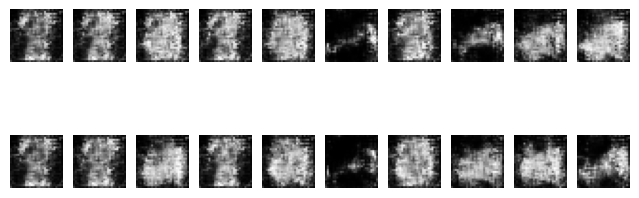

4/4 [==============================] - 0s 3ms/step
Epoch: 200 [D loss: 0.510992, acc.: 100.00%, op_acc: 82.00%] [G loss: 1.456390]
1/1 [==============================] - 0s 23ms/step


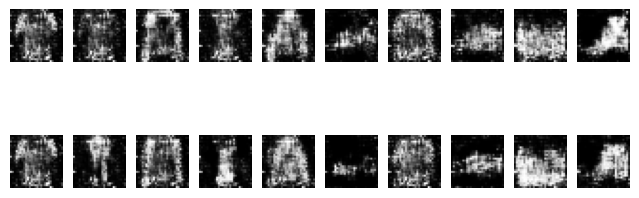

4/4 [==============================] - 0s 4ms/step
Epoch: 400 [D loss: 0.364602, acc.: 100.00%, op_acc: 86.00%] [G loss: 1.225459]
1/1 [==============================] - 0s 19ms/step


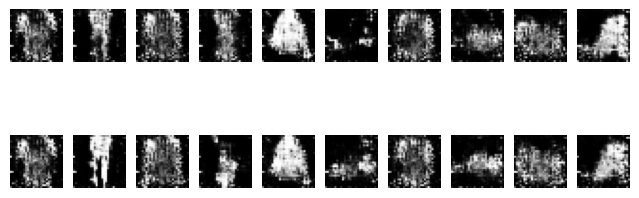

4/4 [==============================] - 0s 4ms/step
Epoch: 600 [D loss: 0.323739, acc.: 100.00%, op_acc: 90.00%] [G loss: 1.388198]
1/1 [==============================] - 0s 17ms/step


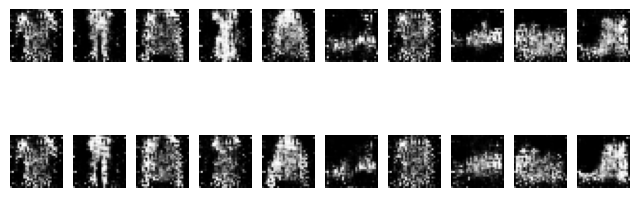

4/4 [==============================] - 0s 6ms/step
Epoch: 800 [D loss: 0.319756, acc.: 100.00%, op_acc: 89.00%] [G loss: 1.211433]
1/1 [==============================] - 0s 17ms/step


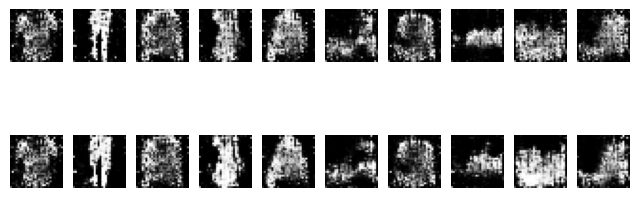

4/4 [==============================] - 0s 6ms/step
Epoch: 1000 [D loss: 0.283211, acc.: 100.00%, op_acc: 89.50%] [G loss: 1.146947]
1/1 [==============================] - 0s 18ms/step


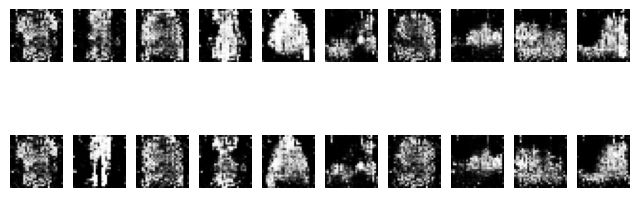

4/4 [==============================] - 0s 6ms/step
Epoch: 1200 [D loss: 0.237604, acc.: 100.00%, op_acc: 91.50%] [G loss: 0.224722]
1/1 [==============================] - 0s 19ms/step


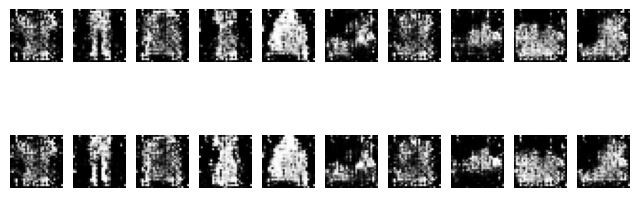

4/4 [==============================] - 0s 3ms/step
Epoch: 1400 [D loss: 0.269320, acc.: 100.00%, op_acc: 88.50%] [G loss: 1.292001]
1/1 [==============================] - 0s 18ms/step


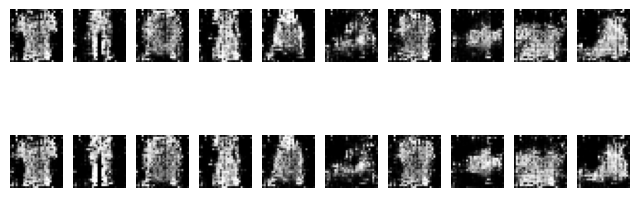

4/4 [==============================] - 0s 5ms/step
Epoch: 1600 [D loss: 0.310824, acc.: 100.00%, op_acc: 90.50%] [G loss: 1.180068]
1/1 [==============================] - 0s 20ms/step


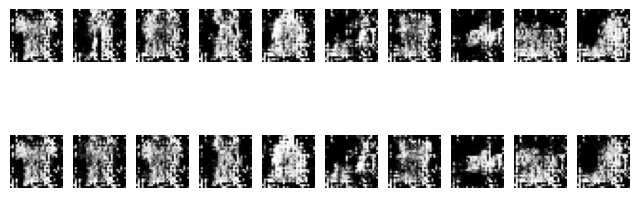

4/4 [==============================] - 0s 6ms/step
Epoch: 1800 [D loss: 0.227195, acc.: 100.00%, op_acc: 89.50%] [G loss: 1.479903]
1/1 [==============================] - 0s 33ms/step


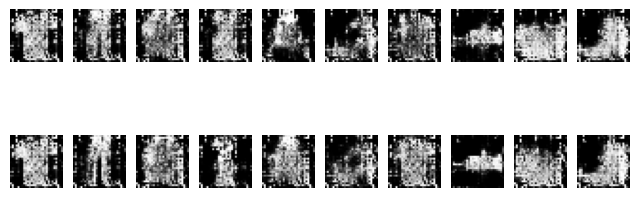

4/4 [==============================] - 0s 4ms/step


In [ ]:
#Train the dataset for 2000 epochs and visualize the preds every 200 epochs to analyze the improvements
g_loss , d_loss = fashion_acgan.train(X_train ,
                                      y_train ,
                                      epochs = 2000,
                                      batch_size = 100,
                                      sample_interval = 200)

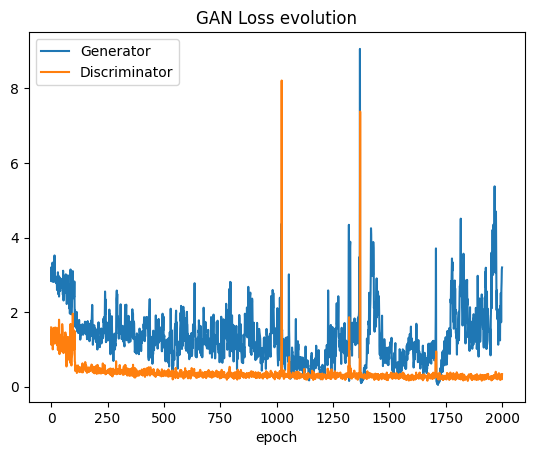

In [ ]:
#Plot loss and accuracy curves
def plot_gan_losses(g_loss, d_loss):
    plt.plot(g_loss)
    plt.plot(d_loss)
    plt.title('GAN Loss evolution')
    plt.ylabel('')
    plt.xlabel('epoch')
    plt.legend(['Generator', 'Discriminator'], loc='upper left')
    plt.show()

plot_gan_losses(g_loss, d_loss)

2/2 [==============================] - 0s 138ms/step


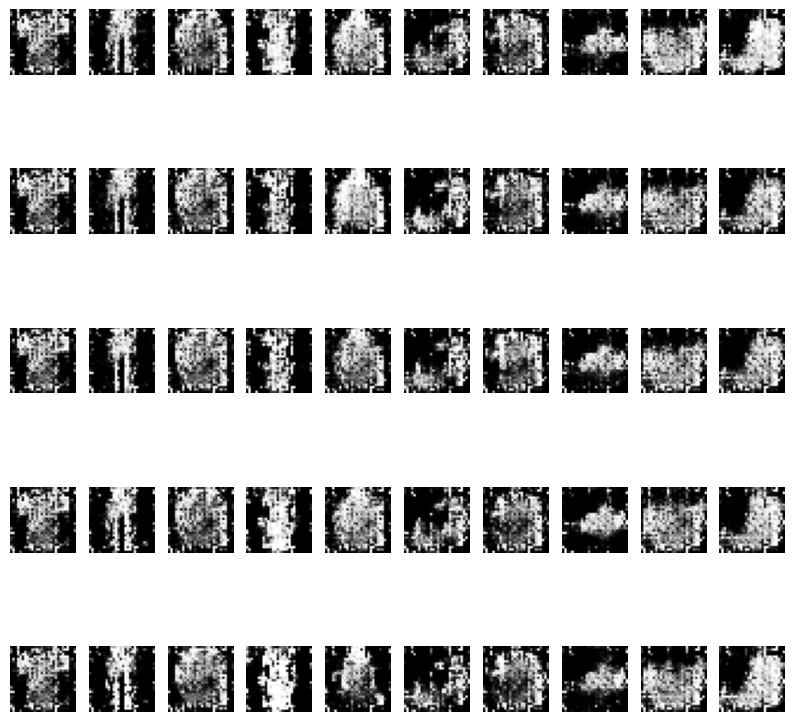

In [ ]:
#A sample of the generated images
fashion_acgan.sample_images(0, smp_rows=5, smp_cols=10, save_img=False, fig_size=(10, 10))

In [ ]:
id_label_sample = 8
#yet another noise sample
yan = np.random.normal(0, 1, (1, 100))
img_smp = fashion_acgan.generator.predict([yan, np.array(id_label_sample).reshape(1, )])[0, :, :, 0]
img_smp = img_smp*0.5 + 0.5

1/1 [==============================] - 0s 119ms/step


In [ ]:
#Plot some related images based on a given image
def plot_n_closest(img_smp, id_label_sample, X_train, N_closest, fig_size=(8, 3)):
    #get the images that belong to id_label_sample
    idx_lab = np.where(y_train==id_label_sample)
    X_lab = (X_train[idx_lab, :, :].astype(np.float32) / 255)[0, :, :, :]
    
    #apply the norm between X_lab and the sampled image across all images
    L1d = np.sum(np.apply_along_axis(np.linalg.norm, -1, X_lab - img_smp, ord=1), axis=1)
    idx_l1_sort = L1d.argsort()
    #plt.imshow(X_lab[idx_l1_sort[0], :, :], cmap='gray')
    fig, axs = plt.subplots(1, N_closest, figsize=fig_size)
    for i in range(N_closest):
        axs[i].imshow(X_lab[idx_l1_sort[i], :, :], cmap='gray')
        axs[i].axis('off')
    plt.show()

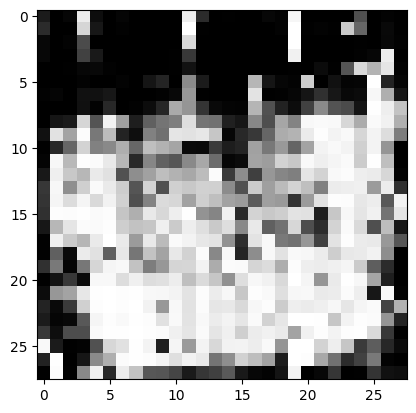

In [ ]:
#original image
plt.imshow(img_smp, cmap='gray')

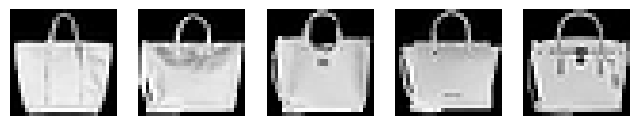

In [ ]:
plot_n_closest(img_smp, 8, X_train, 5, fig_size=(8, 8))